In [175]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

In [176]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [177]:
datasets = MNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
print(datasets)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [178]:
import matplotlib.pyplot as plt
%matplotlib inline

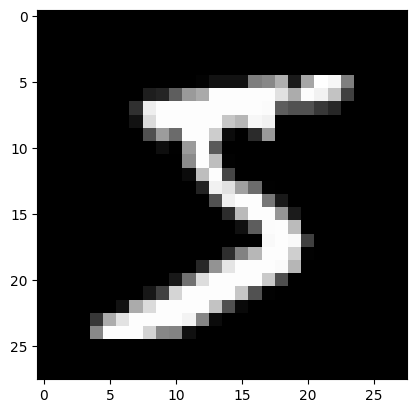

In [179]:
img_tensor, label = datasets[0]
plt.imshow(img_tensor[0], cmap='gray')

In [180]:
n = len(datasets)
val_pct = 0.2
n_val = int(val_pct * n)
idxs = torch.randperm(n)

In [181]:
import numpy as np

def split_indices(n, val_pct):
    n_val = int(val_pct * n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [182]:
train_indices, val_indices = split_indices(len(datasets), val_pct=0.2)
print(len(train_indices), len(val_indices))

48000 12000


In [183]:
batch_size = 100
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, sampler=train_sampler)

val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, sampler=val_sampler)

In [200]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_sizes, out_size):
        super().__init__()
        self.layers = nn.ModuleList()
        
        # First hidden layer
        self.layers.append(nn.Linear(in_size, hidden_sizes[0]))
        
        # Additional hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], out_size))
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)  # Flatten the input
        for layer in self.layers[:-1]:
            xb = layer(xb)
            xb = F.relu(xb)  # You can choose any activation function here
        out = self.layers[-1](xb)  # Final output layer
        return out

# Set input size, hidden layer sizes, and output size
input_size = 784  # 28*28 for MNIST images
hidden_sizes = [128, 64]  # Three hidden layers with sizes 128, 64, and 32
num_classes = 10  # Number of output classes for digit classification

# Instantiate the model
model = MnistModel(input_size, hidden_sizes, num_classes)


In [201]:
torch.cuda.is_available()
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [202]:
device = get_default_device()
device

device(type='cuda')

In [203]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [204]:
for images,labels in train_loader:
    print(images.shape)
    images = to_device(images,device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [205]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self,dl)

In [206]:
train_dl = DeviceDataLoader(train_loader,device)
valid_dl = DeviceDataLoader(val_loader,device)

In [207]:
for xb,yb in valid_dl:
    print('xb_device ', xb.device)
    print('yb: ',yb)
    break

xb_device  cuda:0
yb:  tensor([2, 2, 0, 7, 2, 1, 9, 8, 1, 1, 2, 4, 9, 3, 4, 0, 3, 9, 8, 9, 8, 3, 1, 1,
        8, 0, 7, 6, 1, 5, 4, 8, 1, 4, 1, 4, 0, 6, 0, 6, 6, 9, 6, 2, 2, 4, 7, 0,
        5, 3, 7, 7, 2, 4, 9, 5, 4, 4, 2, 9, 1, 7, 9, 7, 3, 4, 0, 8, 2, 4, 7, 1,
        8, 8, 0, 4, 7, 7, 1, 5, 1, 9, 7, 6, 7, 3, 1, 6, 4, 7, 4, 9, 4, 8, 9, 9,
        8, 7, 8, 3], device='cuda:0')


In [208]:
import torch.nn.functional as F

In [209]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [210]:
loss_fn = F.cross_entropy

In [211]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    if metric is not None:
        metric_result = metric(model(xb), yb)
    return loss.item(), len(xb), metric_result

In [212]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results) #unzipping
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None: #what is metric? accuracy
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [213]:
def fit(epochs,lr,model, loss_fn,train_dl, valid_dl, metric=None,opt=None):
    losses,metrics = [],[]
    if opt is None : opt = torch.optim.SGD
    opt = torch.optim.SGD(model.parameters(),lr=lr)
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)
        
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        losses.append(val_loss)
        metrics.append(val_metric)
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__, val_metric))
    return losses,metrics

In [214]:
model = MnistModel(input_size,hidden_sizes,out_size=num_classes)
to_device(model,device)

MnistModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [215]:
losses1,metric1 = fit(25,0.4, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/25], Loss: 0.1797, accuracy: 0.9467
Epoch [2/25], Loss: 0.1399, accuracy: 0.9584
Epoch [3/25], Loss: 0.1126, accuracy: 0.9666
Epoch [4/25], Loss: 0.0987, accuracy: 0.9704
Epoch [5/25], Loss: 0.0822, accuracy: 0.9745
Epoch [6/25], Loss: 0.0991, accuracy: 0.9718
Epoch [7/25], Loss: 0.0890, accuracy: 0.9757
Epoch [8/25], Loss: 0.1088, accuracy: 0.9707
Epoch [9/25], Loss: 0.0951, accuracy: 0.9743
Epoch [10/25], Loss: 0.1046, accuracy: 0.9734
Epoch [11/25], Loss: 0.0974, accuracy: 0.9751
Epoch [12/25], Loss: 0.0997, accuracy: 0.9753
Epoch [13/25], Loss: 0.1109, accuracy: 0.9738
Epoch [14/25], Loss: 0.0965, accuracy: 0.9784
Epoch [15/25], Loss: 0.0961, accuracy: 0.9787
Epoch [16/25], Loss: 0.0953, accuracy: 0.9781
Epoch [17/25], Loss: 0.0969, accuracy: 0.9793
Epoch [18/25], Loss: 0.0977, accuracy: 0.9790
Epoch [19/25], Loss: 0.0985, accuracy: 0.9791
Epoch [20/25], Loss: 0.1010, accuracy: 0.9784
Epoch [21/25], Loss: 0.1003, accuracy: 0.9789
Epoch [22/25], Loss: 0.1021, accuracy: 0.97

In [216]:
losses1,metric1 = fit(10,0.1, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/10], Loss: 0.1043, accuracy: 0.9787
Epoch [2/10], Loss: 0.1047, accuracy: 0.9788
Epoch [3/10], Loss: 0.1049, accuracy: 0.9788
Epoch [4/10], Loss: 0.1050, accuracy: 0.9789
Epoch [5/10], Loss: 0.1052, accuracy: 0.9788
Epoch [6/10], Loss: 0.1053, accuracy: 0.9791
Epoch [7/10], Loss: 0.1055, accuracy: 0.9791
Epoch [8/10], Loss: 0.1056, accuracy: 0.9790
Epoch [9/10], Loss: 0.1058, accuracy: 0.9789
Epoch [10/10], Loss: 0.1059, accuracy: 0.9790


In [218]:
losses1,metric1 = fit(10,0.1, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/10], Loss: 0.1065, accuracy: 0.9790
Epoch [2/10], Loss: 0.1067, accuracy: 0.9790
Epoch [3/10], Loss: 0.1067, accuracy: 0.9790
Epoch [4/10], Loss: 0.1069, accuracy: 0.9789
Epoch [5/10], Loss: 0.1071, accuracy: 0.9789
Epoch [6/10], Loss: 0.1072, accuracy: 0.9789
Epoch [7/10], Loss: 0.1074, accuracy: 0.9791
Epoch [8/10], Loss: 0.1075, accuracy: 0.9789
Epoch [9/10], Loss: 0.1075, accuracy: 0.9790
Epoch [10/10], Loss: 0.1077, accuracy: 0.9788


Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Label: 7


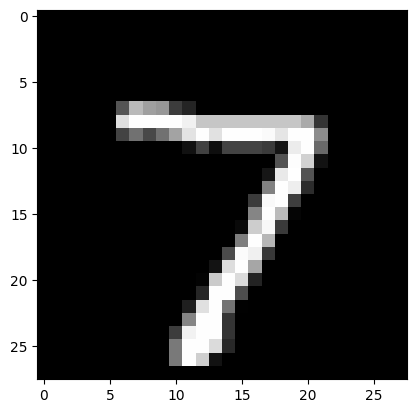

In [219]:
test_datasets = MNIST(root='./data', train=False, download=True,transform=transforms.ToTensor())
print(test_datasets)
import matplotlib.pyplot as plt
%matplotlib inline
image, label = test_datasets[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [220]:
def evaluate_model_with_batches(test_loader, model):
    correct = 0
    total = 0

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        for images, labels in test_loader:
            # Get model predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)

            # Update the total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy on the entire test dataset: {accuracy:.2f}%')

In [221]:
from torch.utils.data import DataLoader
test_loader = DataLoader(dataset=test_datasets, batch_size=64, shuffle=True)
device = torch.device('cpu')
to_device(model,device)
evaluate_model_with_batches(test_loader, model)

Accuracy on the entire test dataset: 98.11%
